In [ ]:
!pip uninstall -y numpy pandas thinc spacy gensim scipy

# Install numpy compatible with thinc and pandas
!pip install numpy==1.26.2

# Install pandas required by Google Colab
!pip install pandas==2.2.2

# Install thinc compatible with spacy
!pip install thinc==8.3.6

# Install spacy compatible with thinc and numpy
!pip install spacy==3.7.6

# Reinstall gensim and scipy
!pip install gensim scipy


import numpy as np
import pandas as pd
from gensim.models import Word2Vec
import spacy

print("NumPy version:", np.__version__)
print("Pandas version:", pd.__version__)
print("Packages imported successfully!")


Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: pandas 2.2.2
Uninstalling pandas-2.2.2:
  Successfully uninstalled pandas-2.2.2
Found existing installation: thinc 8.2.5
Uninstalling thinc-8.2.5:
  Successfully uninstalled thinc-8.2.5
Found existing installation: spacy 3.7.6
Uninstalling spacy-3.7.6:
  Successfully uninstalled spacy-3.7.6
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
Found existing installation: scipy 1.13.1
Uninstalling scipy-1.13.1:
  Successfully uninstalled scipy-1.13.1
  Using cached numpy-1.26.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.2-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following 

In [ ]:
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb
from collections import Counter
import math

# Load your preprocessed CSV file
df = pd.read_csv('labelled_news_sentiment.csv')

# Tokenize the processed text
df['tokens'] = df['processed_text'].apply(lambda x: x.split())

print("Sample tokens:", df['tokens'].head())

# Prepare the corpus: a list of token lists
corpus = df['tokens'].tolist()

# Train the Word2Vec model
w2v_model = Word2Vec(sentences=corpus,
                     vector_size=500,    # Dimension of the word vectors
                     window=10,           # Context window size
                     min_count=1,        # Minimum frequency for a word to be considered
                     workers=10,          # Number of threads for training
                     epochs=30)

print("Word2Vec model trained.")

# Calculate IDF values for all words in the corpus
def calculate_idf(corpus):
    """
    Calculate IDF (Inverse Document Frequency) for each word in the corpus.
    """
    total_documents = len(corpus)
    word_document_count = Counter()

    # Count how many documents each word appears in
    for document in corpus:
        unique_words = set(document)
        for word in unique_words:
            word_document_count[word] += 1

    # Calculate IDF using the formula: log(N / (1 + df))
    idf_values = {word: math.log(total_documents / (1 + count)) for word, count in word_document_count.items()}
    return idf_values

idf_values = calculate_idf(corpus)

def calculate_tfidf_weighted_doc_vector(tokens, idf_values, w2v_model):
    """
    Calculate TF-IDF weighted average of Word2Vec vectors for a document.

    Parameters:
    - tokens: List of tokens in the document.
    - idf_values: Precomputed IDF values for all words.
    - w2v_model: Trained Word2Vec model.

    Returns:
    - Weighted average vector representation of the document.
    """
    # Calculate term frequency (TF) for this document
    tf_values = Counter(tokens)
    total_terms = len(tokens)

    # Normalize TF by dividing by total terms in the document
    tf_values = {word: count / total_terms for word, count in tf_values.items()}

    # Initialize variables for weighted vector calculation
    weighted_sum = np.zeros(w2v_model.vector_size)
    total_weight = 0.0

    # Calculate TF-IDF weighted vectors
    for token in tokens:
        if token in w2v_model.wv and token in idf_values:
            tfidf_score = tf_values[token] * idf_values[token]  # TF-IDF score
            weighted_sum += w2v_model.wv[token] * tfidf_score  # Weighted vector sum
            total_weight += tfidf_score

    # Return normalized weighted average vector or zero vector if no valid tokens are found
    if total_weight > 0:
        return weighted_sum / total_weight
    else:
        return np.zeros(w2v_model.vector_size)

# Generate document vectors using TF-IDF weighting
doc_vectors = []
for tokens in df['tokens']:
    doc_vector = calculate_tfidf_weighted_doc_vector(tokens, idf_values, w2v_model)
    doc_vectors.append(doc_vector)

doc_vectors = np.array(doc_vectors)
print("Document vectors shape:", doc_vectors.shape)

X = doc_vectors
y = df['news_sentiment'].values


Sample tokens: 0    [nod, stake, sale, hdfc, gen, insurance, insur...
1    [citi, cut, job, india, citigroup, inc, say, w...
2    [mha, bat, smse, bank, transaction, atm, slip,...
3    [federal, bank, get, fipb, nod, raise, foreign...
4    [provide, loan, urban, development, evince, in...
Name: tokens, dtype: object
Word2Vec model trained.
Document vectors shape: (29990, 500)


In [ ]:
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (29990, 500)
Shape of y: (29990,)


# PCA Implementation for Dimensionality Reduction

In [ ]:
from sklearn.preprocessing import StandardScaler

# Standardize the document vectors
scaler = StandardScaler()
doc_vectors_scaled = scaler.fit_transform(doc_vectors)

print("Shape after scaling:", doc_vectors_scaled.shape)


Shape after scaling: (29990, 500)


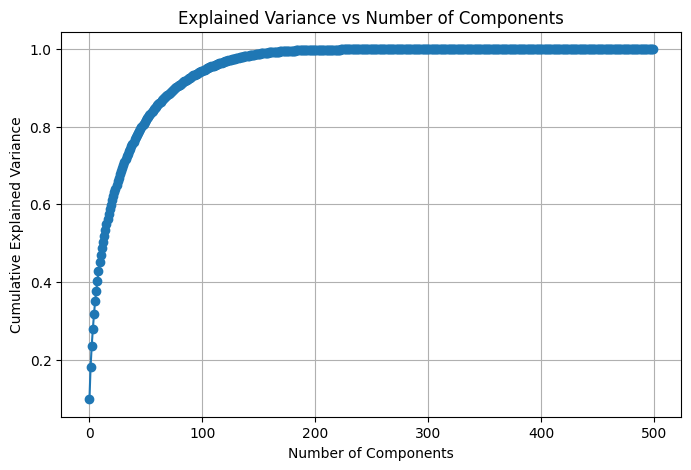

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Initialize PCA and fit it to the scaled data
pca = PCA()
pca.fit(doc_vectors_scaled)

# Plot cumulative explained variance to decide the number of components
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Components')
plt.grid()
plt.show()


In [ ]:
# Set the number of components (e.g., 100)
n_components = 100

# Apply PCA with the chosen number of components
pca = PCA(n_components=n_components)
X_reduced = pca.fit_transform(doc_vectors_scaled)

print("Shape after PCA:", X_reduced.shape)


Shape after PCA: (29990, 100)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost regression
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model with early stopping
xgb_model = xgb.train(params, dtrain, num_boost_round=100,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10, verbose_eval=True)

# Use the trained model for predictions
y_pred = xgb_model.predict(dtest)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("\nFinal Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
maa = np.mean(np.abs(y_test))
print(f"Mean Absolute Average (MAA): {maa:.4f}")


Shape of X_train: (23992, 100)
Shape of X_test: (5998, 100)
[0]	train-rmse:0.45541	test-rmse:0.45452
[1]	train-rmse:0.44885	test-rmse:0.44857
[2]	train-rmse:0.44347	test-rmse:0.44405
[3]	train-rmse:0.43877	test-rmse:0.43983
[4]	train-rmse:0.43437	test-rmse:0.43658
[5]	train-rmse:0.43082	test-rmse:0.43368
[6]	train-rmse:0.42691	test-rmse:0.43098
[7]	train-rmse:0.42327	test-rmse:0.42853
[8]	train-rmse:0.42010	test-rmse:0.42613
[9]	train-rmse:0.41732	test-rmse:0.42401
[10]	train-rmse:0.41446	test-rmse:0.42218
[11]	train-rmse:0.41179	test-rmse:0.42033
[12]	train-rmse:0.40920	test-rmse:0.41832
[13]	train-rmse:0.40691	test-rmse:0.41666
[14]	train-rmse:0.40477	test-rmse:0.41519
[15]	train-rmse:0.40267	test-rmse:0.41354
[16]	train-rmse:0.40059	test-rmse:0.41227
[17]	train-rmse:0.39848	test-rmse:0.41076
[18]	train-rmse:0.39661	test-rmse:0.40957
[19]	train-rmse:0.39464	test-rmse:0.40864
[20]	train-rmse:0.39291	test-rmse:0.40731
[21]	train-rmse:0.39116	test-rmse:0.40619
[22]	train-rmse:0.38943	te

# Implementing various Feature Selection Techniques


In [ ]:
from sklearn.feature_selection import VarianceThreshold

# Set a threshold for variance (e.g., 0.01)
threshold = 0.08
selector = VarianceThreshold(threshold=threshold)

# Apply the filter
X_low_variance = selector.fit_transform(doc_vectors)

print("Shape after low variance filter:", X_low_variance.shape)


Shape after low variance filter: (29990, 382)


In [ ]:
import pandas as pd
import numpy as np

# Convert document vectors to a DataFrame for easier manipulation
df_features = pd.DataFrame(doc_vectors)

# Compute the correlation matrix
correlation_matrix = df_features.corr()

# Identify highly correlated features (e.g., correlation > 0.9)
high_corr_pairs = np.where(np.abs(correlation_matrix) > 0.9)
high_corr_pairs = [(i, j) for i, j in zip(*high_corr_pairs) if i != j and i < j]

print("Highly correlated feature pairs:", high_corr_pairs)

# Drop one feature from each pair of highly correlated features
features_to_drop = set()
for i, j in high_corr_pairs:
    features_to_drop.add(j)  # Arbitrarily drop the second feature in each pair

df_features_filtered = df_features.drop(columns=list(features_to_drop))

print("Shape after high correlation filter:", df_features_filtered.shape)


Highly correlated feature pairs: []
Shape after high correlation filter: (29990, 500)


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler

# Standardize the data before applying Lasso
scaler = StandardScaler()
X_scaled = scaler.fit_transform(doc_vectors)

# Fit Lasso regression with regularization parameter alpha
lasso = Lasso(alpha=0.01)  # Adjust alpha based on your dataset
lasso.fit(X_scaled, y)

# Get selected features (non-zero coefficients)
selected_features = np.where(lasso.coef_ != 0)[0]
X_lasso_selected = X_scaled[:, selected_features]

print("Shape after Lasso feature selection:", X_lasso_selected.shape)


Shape after Lasso feature selection: (29990, 74)


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_low_variance, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost regression
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model with early stopping
xgb_model_low_variance = xgb.train(params, dtrain, num_boost_round=100,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10, verbose_eval=True)

# Use the trained model for predictions
y_pred = xgb_model_low_variance.predict(dtest)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("\nFinal Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Shape of X_train: (23992, 382)
Shape of X_test: (5998, 382)
[0]	train-rmse:0.45304	test-rmse:0.45230
[1]	train-rmse:0.44602	test-rmse:0.44618
[2]	train-rmse:0.43985	test-rmse:0.44121
[3]	train-rmse:0.43403	test-rmse:0.43650
[4]	train-rmse:0.42870	test-rmse:0.43223
[5]	train-rmse:0.42397	test-rmse:0.42839
[6]	train-rmse:0.41972	test-rmse:0.42515
[7]	train-rmse:0.41557	test-rmse:0.42185
[8]	train-rmse:0.41186	test-rmse:0.41928
[9]	train-rmse:0.40814	test-rmse:0.41652
[10]	train-rmse:0.40497	test-rmse:0.41414
[11]	train-rmse:0.40168	test-rmse:0.41187
[12]	train-rmse:0.39839	test-rmse:0.40957
[13]	train-rmse:0.39544	test-rmse:0.40756
[14]	train-rmse:0.39269	test-rmse:0.40572
[15]	train-rmse:0.39001	test-rmse:0.40389
[16]	train-rmse:0.38760	test-rmse:0.40219
[17]	train-rmse:0.38538	test-rmse:0.40099
[18]	train-rmse:0.38304	test-rmse:0.39964
[19]	train-rmse:0.38110	test-rmse:0.39850
[20]	train-rmse:0.37910	test-rmse:0.39721
[21]	train-rmse:0.37723	test-rmse:0.39601
[22]	train-rmse:0.37534	te

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_lasso_selected, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost regression
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model with early stopping
xgb_model_lasso_reg = xgb.train(params, dtrain, num_boost_round=100,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10, verbose_eval=True)

# Use the trained model for predictions
y_pred = xgb_model_lasso_reg.predict(dtest)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("\nFinal Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Shape of X_train: (23992, 74)
Shape of X_test: (5998, 74)
[0]	train-rmse:0.45337	test-rmse:0.45233
[1]	train-rmse:0.44640	test-rmse:0.44645
[2]	train-rmse:0.43996	test-rmse:0.44079
[3]	train-rmse:0.43431	test-rmse:0.43611
[4]	train-rmse:0.42886	test-rmse:0.43165
[5]	train-rmse:0.42431	test-rmse:0.42777
[6]	train-rmse:0.42020	test-rmse:0.42465
[7]	train-rmse:0.41628	test-rmse:0.42156
[8]	train-rmse:0.41238	test-rmse:0.41839
[9]	train-rmse:0.40889	test-rmse:0.41599
[10]	train-rmse:0.40574	test-rmse:0.41354
[11]	train-rmse:0.40248	test-rmse:0.41122
[12]	train-rmse:0.39944	test-rmse:0.40885
[13]	train-rmse:0.39679	test-rmse:0.40687
[14]	train-rmse:0.39446	test-rmse:0.40556
[15]	train-rmse:0.39197	test-rmse:0.40376
[16]	train-rmse:0.38969	test-rmse:0.40191
[17]	train-rmse:0.38739	test-rmse:0.40040
[18]	train-rmse:0.38530	test-rmse:0.39898
[19]	train-rmse:0.38328	test-rmse:0.39797
[20]	train-rmse:0.38142	test-rmse:0.39690
[21]	train-rmse:0.37959	test-rmse:0.39555
[22]	train-rmse:0.37797	test

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import xgboost as xgb

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)

# Convert to DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Set parameters for XGBoost regression
params = {
    'objective': 'reg:squarederror',
    'max_depth': 5,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Train the model with early stopping
xgb_model = xgb.train(params, dtrain, num_boost_round=100,
                      evals=[(dtrain, 'train'), (dtest, 'test')],
                      early_stopping_rounds=10, verbose_eval=True)

# Use the trained model for predictions
y_pred = xgb_model.predict(dtest)

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test, y_pred)
print("\nFinal Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Shape of X_train: (23992, 500)
Shape of X_test: (5998, 500)
[0]	train-rmse:0.45307	test-rmse:0.45230
[1]	train-rmse:0.44587	test-rmse:0.44617
[2]	train-rmse:0.43969	test-rmse:0.44122
[3]	train-rmse:0.43394	test-rmse:0.43644
[4]	train-rmse:0.42828	test-rmse:0.43175
[5]	train-rmse:0.42323	test-rmse:0.42755
[6]	train-rmse:0.41839	test-rmse:0.42388
[7]	train-rmse:0.41397	test-rmse:0.42064
[8]	train-rmse:0.41013	test-rmse:0.41775
[9]	train-rmse:0.40647	test-rmse:0.41522
[10]	train-rmse:0.40301	test-rmse:0.41276
[11]	train-rmse:0.39970	test-rmse:0.41073
[12]	train-rmse:0.39672	test-rmse:0.40841
[13]	train-rmse:0.39380	test-rmse:0.40623
[14]	train-rmse:0.39110	test-rmse:0.40440
[15]	train-rmse:0.38833	test-rmse:0.40266
[16]	train-rmse:0.38602	test-rmse:0.40110
[17]	train-rmse:0.38375	test-rmse:0.39979
[18]	train-rmse:0.38132	test-rmse:0.39796
[19]	train-rmse:0.37919	test-rmse:0.39668
[20]	train-rmse:0.37706	test-rmse:0.39517
[21]	train-rmse:0.37504	test-rmse:0.39396
[22]	train-rmse:0.37307	te

In [ ]:
import pickle
with open('trained_models/xgboost_model.pkl','wb') as f:
  pickle.dump(xgb_model,f)

In [ ]:
# Save the trained model to a file
w2v_model.save("trained_models/word2vec_model.model")
print("Word2Vec model trained and saved to 'word2vec_model.model'")

Word2Vec model trained and saved to 'word2vec_model.model'
